# HW Guide Part B: Replicate Fama-French 1993

**Summary**

The Fama and French (1993) paper, "Common Risk Factors in the Returns on Stocks and Bonds," revolutionized asset pricing theory by challenging the Capital Asset Pricing Model (CAPM) with a three-factor model that includes market risk, size (market capitalization), and book-to-market value as predictors of stock returns. They demonstrated that the market factor alone does not fully explain stock returns and that small stocks and stocks with high book-to-market ratios yield higher returns than can be explained
by market beta alone, suggesting that these factors capture additional risks not accounted for by the CAPM. This seminal work has significantly influenced academic research and investment practices by highlighting the importance of size and value factors in asset pricing, thereby laying the groundwork for more sophisticated models and strategies in finance.

**Game Plan**

The code underlying this notebook follows the methodology described in https://wrds-www.wharton.upenn.edu/pages/wrds-research/applications/risk-factors-and-industry-benchmarks/fama-french-factors/ . I will quote from that methodology extensively. There is also a set
of videos on this linked website. Those may be helpful for this exercise.

The code is lightly edited from the code provided by WRDS on their website.



In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from pandas.tseries.offsets import MonthEnd, YearEnd
import numpy as np
from scipy import stats
import datetime

import load_CRSP_Compustat
import calc_Fama_French_1993_factors

import config

DATA_DIR = config.DATA_DIR

## Step 1. Load Data

In order to replicate the factors from this paper, we need data from CRSP and Compustat.
The CRSP data provides the stock prices while Compustat provides the fundamentals.
We also use the CRSP/Compustat Linking Table to merge the two data. The merge is not
straightforward, but there is a standard procedure used that is embodied in the linking table
provided by CRSP and available on WRDS.

In [2]:
comp = load_CRSP_Compustat.load_compustat(data_dir=DATA_DIR)
crsp = load_CRSP_Compustat.load_CRSP_stock_ciz(data_dir=DATA_DIR)
ccm = load_CRSP_Compustat.load_CRSP_Comp_Link_Table(data_dir=DATA_DIR)

# Prep Data

## Step 2. Calculate Book Equity

"We used Compustat XpressFeed (annual data) as the source of historical accounting data in order to calculate the value of Book Equity. Different from quarterly data, annual data is unrestated (ideal for backtesting). Book Equity is defined as the Compustat book value of stockholders' equity plus balance sheet deferred taxes and investment tax credit (if available) minus book value of preferred stock. We did not modify the original formula that adds deferred taxes and investment tax credit. According to Kenneth French's website (as of May 2018) , it had been changes to the treatment of deferred taxes described in FASB 109.

To estimate book value of preferred stock they use the redemption or liquidation or par value of preferred stock (in that order). Since Book Equity is almost missing for the whole sample during the 1950's, we constrained our sample to begin in 1960. Additionally, we created a variable that counts number of annual records in Compustat files."

In [3]:
comp = calc_Fama_French_1993_factors.calc_book_equity_and_years_in_compustat(comp)

In [4]:
comp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 558633 entries, 0 to 58632
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   gvkey     558633 non-null  object        
 1   datadate  558633 non-null  datetime64[ns]
 2   year      558633 non-null  int32         
 3   be        412213 non-null  float64       
 4   count     558633 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(1)
memory usage: 23.4+ MB


## Step 3. Subset CRSP to Common Stock and Proper Exchanges

NOTE: I am using the updates CIZ version of the CRSP flat file. This means that I don't have to merge the CRSP event files with the time series files and I don't need to apply delisting returns, as they are already applied. 

"For the purpose of this procedure we used CRSP monthly data (users can extend this calculation to daily data). The first step in working with CRSP was to merge CRSP "event" and "time-series" files. CRSP event files contain historical information on the exchange code (crucial to identify firms listed in NYSE), share codes (to identify common stocks) and delisting returns. CRSP time-series files (as CRSP.MSF) contain information such as prices, returns and shares outstanding. We merged both files using a macro program (named ‘crspmerge')."

In [5]:
crsp = calc_Fama_French_1993_factors.subset_CRSP_to_common_stock_and_exchanges(crsp)

In [6]:
crsp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3401861 entries, 0 to 51623
Data columns (total 16 columns):
 #   Column            Dtype         
---  ------            -----         
 0   permno            int32         
 1   permco            int32         
 2   mthcaldt          datetime64[ns]
 3   issuertype        object        
 4   securitytype      object        
 5   securitysubtype   object        
 6   sharetype         object        
 7   usincflg          object        
 8   primaryexch       object        
 9   conditionaltype   object        
 10  tradingstatusflg  object        
 11  mthret            float64       
 12  mthretx           float64       
 13  shrout            float64       
 14  mthprc            float64       
 15  jdate             datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int32(2), object(8)
memory usage: 415.3+ MB


In [7]:
crsp.head()

,permno,permco,mthcaldt,issuertype,securitytype,securitysubtype,sharetype,usincflg,primaryexch,conditionaltype,tradingstatusflg,mthret,mthretx,shrout,mthprc,jdate
0,10000,7952,1986-01-31,ACOR,EQTY,COM,NS,Y,Q,RW,A,0.707317,0.707317,3680.0,4.375000,1986-01-31
1,10000,7952,1986-02-28,ACOR,EQTY,COM,NS,Y,Q,RW,A,-0.257143,-0.257143,3680.0,3.250000,1986-02-28
2,10000,7952,1986-03-31,ACOR,EQTY,COM,NS,Y,Q,RW,A,0.365385,0.365385,3680.0,4.437500,1986-03-31
3,10000,7952,1986-04-30,ACOR,EQTY,COM,NS,Y,Q,RW,A,-0.098592,-0.098592,3793.0,4.000000,1986-04-30
4,10000,7952,1986-05-30,ACOR,EQTY,COM,NS,Y,Q,RW,A,-0.222656,-0.222656,3793.0,3.109375,1986-05-31


## Step 4.  Calculate Market Equity

NOTE: I am using the updates CIZ version of the CRSP flat file. This means that I don't have to merge the CRSP event files with the time series files and I don't need to apply delisting returns, as they are already applied. 

"Second, we added delisting returns (to reduce any bias in portfolio returns) and calculated Market Capitalization (ME) for each CRSP security (abs(prc)*shrout). There were cases when the same firm (permco) had two or more securities (permno) on the same date. For the purpose of ME for the firm, we aggregated all ME for a given permco, date. This aggregated ME was assigned to the CRSP permno that has the largest ME. Finally, ME at June and December were flagged since (1) December ME will be used to create Book-to-Market ratio (BEME) and (2) June ME has to be positive in order to be part of the portfolio."

In [8]:
crsp2 = calc_Fama_French_1993_factors.calculate_market_equity(crsp)
crsp3, crsp_jun = calc_Fama_French_1993_factors.use_dec_market_equity(crsp2)

## Step 5. Merge CRSP and Compustat

"We merged CRSP and Compustat using the CRSP CCM product (as of April 2010). We matched Compustat's gvkey (from calendar year t-1) to CRSP's permno as of June year t. Data was cleaned for unnecessary duplicates. First there were cases when different gvkeys exist for same permno-date. We solved these duplicates by only keeping those cases that are flagged as 'primary' matches by CRSP's CCM (linkprim='P' ). There were other unnecessary duplicates that were removed. Some companies may have two annual accounting records in the same calendar year. This is produced by change in the fiscal year end during the same calendar year. In these cases, we selected the last annual record for a given calendar year.

After data cleaning, the book-to-market ratio for every firm in the sample were calculated by dividing Book Equity (for fiscal year that ends on year t-1) over the market value of its common equity at the end of December year t -1. These book-to-market ratios and Market Capitalization (as of December year t-1) were assigned to June year t in order to create portfolios."

In [9]:
ccm_jun = calc_Fama_French_1993_factors.merge_CRSP_and_Compustat(crsp_jun, comp, ccm)

# Create Portfolios and Factors

## Step 6. Create Portfolios by Size and Book-to-Market. 

"Every June (year t) we calculated the median equity value of NYSE-listed firms using Market Capitalization at June t. We used this median to classify firms as Small or Big on portfolios created at the end of June year t. In a similar fashion, as of June year t, firms are broken into three book-to-market equity groups (Low, Medium, and High) based on the 30% and 70% break-points of the NYSE-firms with positive book-to-market equity. In both cases (for size and book-to-market classification), we restricted our sample to those firms with positive book-to-market, positive market cap at June, common equity (share code 10 and 11) and at least two years in Compustat annual file.

We created a total of six size and book-to-market equity portfolios. Portfolios are created at the end of June and kept for 12 months. Within each portfolio a monthly value-weighted return is calculated (each month, the weight is the Market Capitalization as of June year t adjusted by any change in price between the end June t and the end of the previous month)."


In [10]:
ccm4 = calc_Fama_French_1993_factors.assign_size_and_bm_portfolios(ccm_jun, crsp3)
vwret, vwret_n = calc_Fama_French_1993_factors.create_fama_french_portfolios(ccm4)

## Step 7. Calculation of FF factors

"The size factor, Small minus Big (SMB) , is the difference of average return on the three Small-firm portfolios and the average return on the three Big-firm portfolios.

The value factor, High minus Low (HML) , is the difference between the average return on the two High book-to-market equity portfolios and the average return on the two Low book-to-market equity portfolios. For comparison purpose, we also calculate the number of firms in each portfolio."

In [11]:
ff_factors, ff_nfirms = calc_Fama_French_1993_factors.create_factors_from_portfolios(vwret, vwret_n)


# Compare Results of Our Manual Calculation to the Actual Factors

## Step 8. Load actual FF1993 factors from Ken French Data Library (via WRDS)

In [12]:
actual_ff = load_CRSP_Compustat.load_Fama_French_factors(data_dir=DATA_DIR)
actual_ff = actual_ff[["date", "smb", "hml"]]

## Step 9. Merge Actual with Manual Factors

In [13]:
ff_compare = pd.merge(actual_ff, ff_factors[["date", "WSMB", "WHML"]], how="inner", on="date")

ff_compare = ff_compare.rename(columns={
    "smb": "smb_actual", 
    "hml": "hml_actual",
    "WSMB": "smb_manual",
    "WHML": "hml_manual",
    })

ff_compare_post_1970 = ff_compare[ff_compare["date"] >= "01/01/1970"]

ff_compare.set_index("date", inplace=True)
ff_compare_post_1970.set_index("date", inplace=True)

## Step 10. Compare using correlation

In [14]:
print(stats.pearsonr(ff_compare_post_1970["smb_actual"], ff_compare_post_1970["smb_manual"]))
print(stats.pearsonr(ff_compare_post_1970["hml_actual"], ff_compare_post_1970["hml_manual"]))


PearsonRResult(statistic=0.9959567073866312, pvalue=0.0)
PearsonRResult(statistic=0.9838835321678083, pvalue=0.0)


In [15]:
ff_compare.tail(2)

,smb_actual,hml_actual,smb_manual,hml_manual
date,,,,
2022-11-30,-0.0352,0.0138,-0.038361,0.016327
2022-12-31,-0.0069,0.0137,-0.009378,0.012031


## Step 11. Plot Factors to Compare

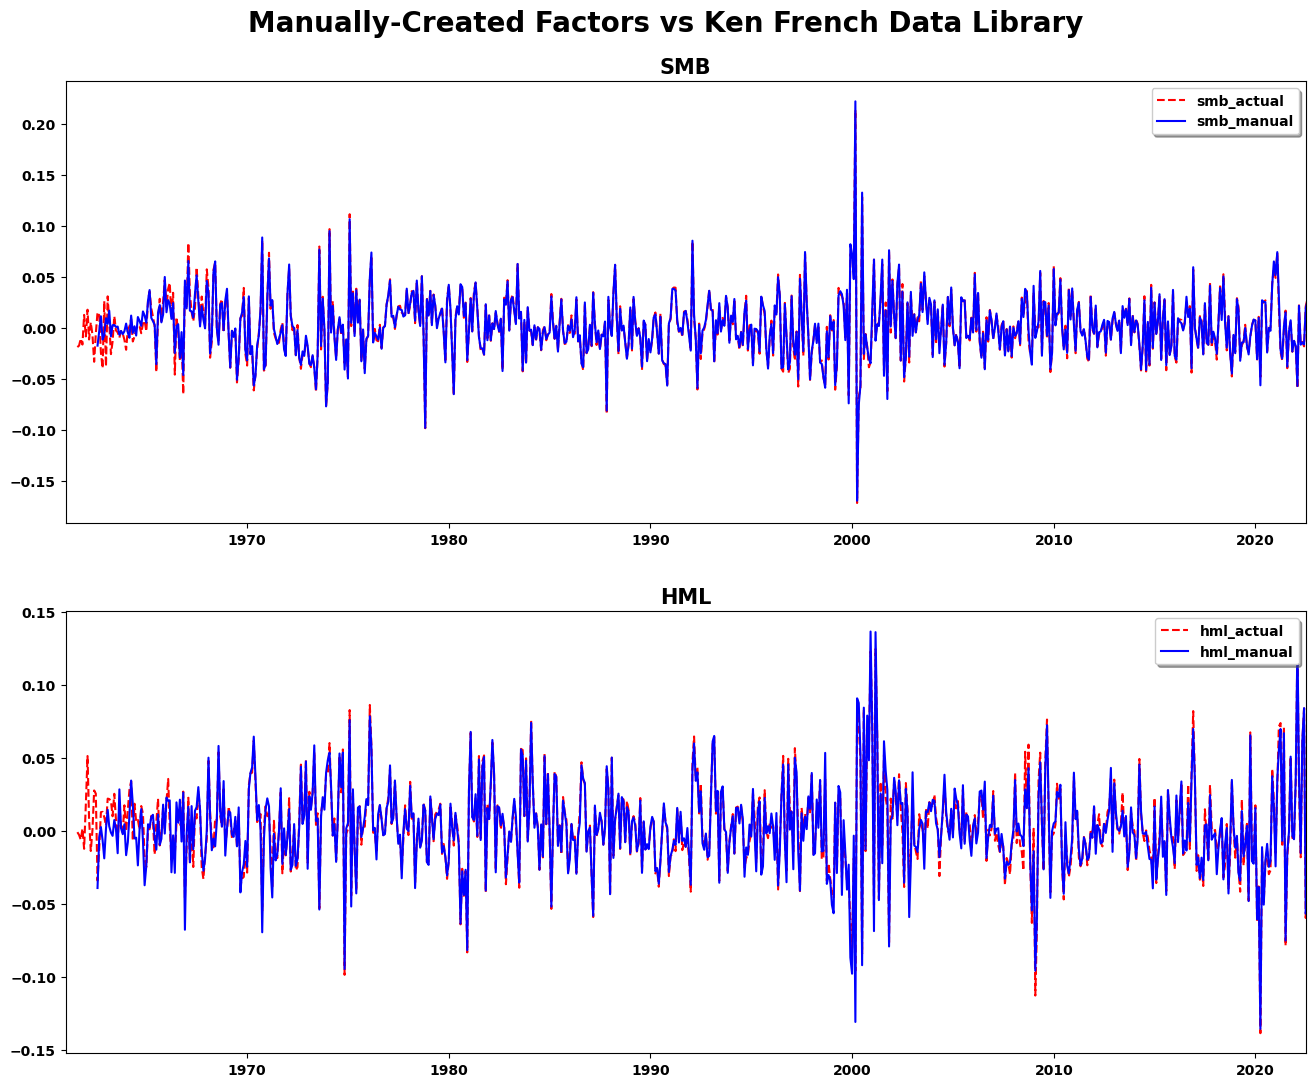

In [16]:
plt.figure(figsize=(16, 12))
plt.suptitle("Manually-Created Factors vs Ken French Data Library", fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title("SMB", fontsize=15)
ax1.set_xlim([datetime.datetime(1961, 1, 1), datetime.datetime(2022, 6, 30)])
ax1.plot(ff_compare["smb_actual"], "r--", ff_compare["smb_manual"], "b-")
ax1.legend(("smb_actual", "smb_manual"), loc="upper right", shadow=True)

ax2 = plt.subplot(212)
ax2.set_title("HML", fontsize=15)
ax2.plot(ff_compare["hml_actual"], "r--", ff_compare["hml_manual"], "b-")
ax2.set_xlim([datetime.datetime(1961, 1, 1), datetime.datetime(2022, 6, 30)])
ax2.legend(("hml_actual", "hml_manual"), loc="upper right", shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)